# Comparison of algorithms to correct NFI coordinates

[Example using ESA World Cover v200 2021](https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v200)

- 10 	: Tree cover
- 20 	: Shrubland
- 30 	: Grassland
- 40 	: Cropland
- 50 	: Built-up
- 60 	: Bare / sparse vegetation
- 70 	: Snow and ice
- 80 	: Permanent water bodies
- 90 	: Herbaceous wetland
- 95 	: Mangroves
- 100 : Moss and lichen

In [3]:
# Libraries
import imageio as io
import numpy as np
from collections import deque
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import geopandas as gpd

import rasterio
from rasterio import warp

%matplotlib inline

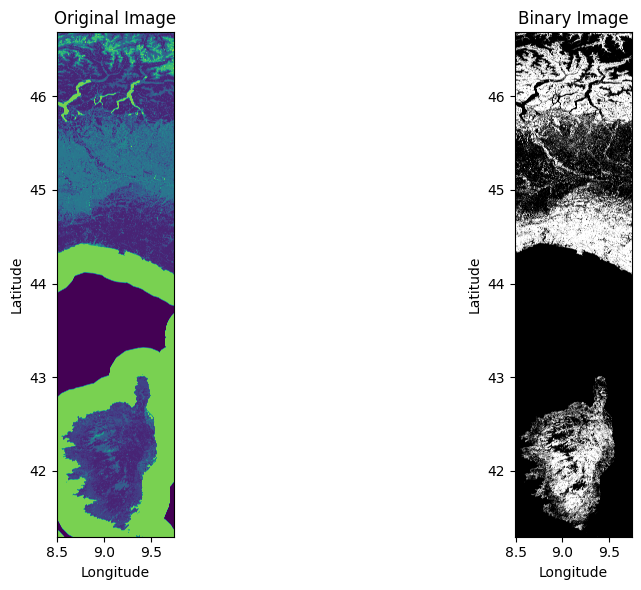

In [30]:
import rasterio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt

# Load the raster file
with rasterio.open("land_cover_esa_v200_part_4 copy.tif") as src:
    # Read the raster data
    image_org = src.read(1)  # Assuming you want to read the first band

    # Copy the original image for manipulation
    image_binary = image_org.copy()

    # Set all values that are not 10 to 0, and all that are 10 to 1
    image_binary[image_org != 10] = 0
    image_binary[image_org == 10] = 1

    # Plot the original and binary images side by side
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Plot original raster
    ax[0].set_title("Original Image")
    ax[0].set_xlabel("Longitude")
    ax[0].set_ylabel("Latitude")
    show(image_org, transform=src.transform, ax=ax[0], cmap="viridis")

    # Plot binary raster
    ax[1].set_title("Binary Image")
    ax[1].set_xlabel("Longitude")
    ax[1].set_ylabel("Latitude")
    show(image_binary, transform=src.transform, ax=ax[1], cmap="viridis")

    plt.tight_layout()
    plt.show()

In [133]:
# Open the raster file
with rasterio.open("land_cover_esa_v200_part_4 copy.tif") as src:
    # Transform the raster to WGS84 format
    transform, width, height = rasterio.warp.calculate_default_transform(
        src.crs, "EPSG:4326", src.width, src.height, *src.bounds
    )
    kwargs = src.meta.copy()
    kwargs.update(
        {
            "crs": "EPSG:4326",
            "transform": transform,
            "width": width,
            "height": height,
        }
    )

    # Read the raster data
    image_org = src.read(
        1,
        out_shape=(src.height, src.width),
        resampling=rasterio.enums.Resampling.bilinear,
    )

image_org

# Turn original image into a binary image
image_binary = image_org.copy()
forest_code = [10]
image_binary[~np.isin(image_binary, forest_code)] = 0  # Set all non-forest pixels to 0
image_binary[np.isin(image_binary, forest_code)] = 1  # Set all forest pixels to 1

# Display both images
fig, ax = plt.subplots(1, 2, figsize=(5, 5))

ax[0].imshow(image_org, extent=warp.transform_bounds(src.crs, "EPSG:4326", *src.bounds))
ax[0].set_title("Original image")
ax[0].set_xlabel("Longitude")
ax[0].set_ylabel("Latitude")
ax[0].set_aspect(5)

ax[1].imshow(
    image_binary, extent=warp.transform_bounds(src.crs, "EPSG:4326", *src.bounds)
)
ax[1].set_title("Binary image")
ax[1].set_xlabel("Longitude")
ax[1].set_ylabel("Latitude")
ax[1].set_aspect(5)

plt.show()

array([[60, 60, 60, ..., 30, 30, 30],
       [60, 60, 60, ..., 30, 30, 30],
       [60, 60, 60, ..., 30, 30, 30],
       ...,
       [80, 80, 80, ..., 80, 80, 80],
       [80, 80, 80, ..., 80, 80, 80],
       [80, 80, 80, ..., 80, 80, 80]], dtype=uint8)

In [40]:
import rasterio
from rasterio.plot import show
from rasterio.windows import Window
import numpy as np
import matplotlib.pyplot as plt

# Inputs
seed_random_point = 1999  # Set random seed
middle_point_radius = 70  # Set pixel radius around middle point
n_window = 5  # Size of the window to calculate forest density

In [2]:
# Function to produce a raster with forest density
def produce_raster_with_forest_density(input_image, n_window):
    
    # Initialize an empty image
    out_image = np.zeros_like(input_image)

    # Loop over each pixel in the reduced image
    for i in range(input_image.shape[0]):
        for j in range(input_image.shape[1]):
            # If the pixel is at the border, that is within the pixels defined by n_window, return a 0
            if (
                i < n_window // 2
                or i >= input_image.shape[0] - n_window // 2
                or j < n_window // 2
                or j >= input_image.shape[1] - n_window // 2
            ):
                out_image[i, j] = 0
            # If the pixel's value in input_image is 0, return 0
            elif input_image[i, j] == 0:
                out_image[i, j] = 0
            # If the pixel is not close to the border and has value 1, then calculate the sum of pixels around it within a n_window times n_window window
            else:
                window = input_image[
                    i - n_window // 2 : i + n_window // 2 + 1,
                    j - n_window // 2 : j + n_window // 2 + 1,
                ]
                out_image[i, j] = np.sum(window)

    return out_image

In [3]:
# Function to zero out a circular area in the raster
def zero_out_circle(image, center_point, radius_in_meters, pixel_size):
    """
    Zero out a circular area in a raster image.

    Parameters:
    image: numpy.ndarray - The raster image to modify.
    center_point: tuple - The (row, col) index of the center point in the image.
    radius_in_meters: int - The radius of the circle to zero out in meters.
    pixel_size: int - The size of one pixel in meters.

    Returns:
    numpy.ndarray - The modified raster image with the circular area zeroed out.
    """
    radius_in_pixels = radius_in_meters // pixel_size

    # Create a binary mask where pixels within the radius will be True
    mask = np.zeros_like(image, dtype=bool)

    # Create an array with the indices of the pixels
    rows, cols = np.indices(image.shape)

    # Calculate the distance of all pixels to the middle point
    distances = np.sqrt((rows - center_point[0]) ** 2 + (cols - center_point[1]) ** 2)

    # Set True in the mask for pixels within the radius
    mask[distances >= radius_in_pixels] = True

    # Set the values to zero in the original image where the mask is True
    image[mask] = 0

    return image

In [22]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point


def extract_nonzero_pixels_to_dataframe(image, transform):
    """
    Extract non-zero pixels from a raster image and return a DataFrame with latitude,
    longitude, and value.

    Parameters:
    image: numpy.ndarray - The raster image to process.
    transform: affine.Affine - The affine transform associated with the raster image.

    Returns:
    DataFrame - A DataFrame with columns for latitude, longitude, and the pixel value.
    """
    # Find indices of all non-zero pixels
    rows, cols = np.nonzero(image)

    # Convert pixel positions to spatial coordinates
    coords = [
        rasterio.transform.xy(transform, row, col, offset="center")
        for row, col in zip(rows, cols)
    ]

    # Extract the values of the non-zero pixels
    values = image[rows, cols]

    # Create a DataFrame
    df = pd.DataFrame(
        {
            "Longitude": [coord[0] for coord in coords],
            "Latitude": [coord[1] for coord in coords],
            "Value": values,
        }
    )

    # Convert DataFrame to GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

    return gdf

In [27]:
from collections import deque
import numpy as np
import rasterio
import warnings


def bfs_closest_pixel(center_point, image, target_value):
    """
    Perform a BFS to find the closest pixel with the target_value to center_point.

    Parameters:
    center_point: tuple - The (row, col) index of the center point relative to the image.
    image: numpy.ndarray - The raster image to search within.
    target_value: int - The pixel value to search for.

    Returns:
    tuple - The (row, col) index of the closest pixel with the target_value, or the original center_point if not found.
    """
    # Quick check if the target_value is in the raster file forest_density_mask
    if target_value not in image:
        warnings.warn(
            f"Value {target_value} not found in the raster. Using the max value instead."
        )
        target_value = np.max(image)

    # Initialize BFS
    rows, cols = image.shape
    visited = np.zeros((rows, cols), dtype=bool)
    queue = deque([center_point])

    # Directions for exploring neighbors: up, down, left, right
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    while queue:
        current_point = queue.popleft()
        current_row, current_col = current_point

        # Check if we found the target_value
        if image[current_row, current_col] == target_value:
            return current_point  # Return the coordinates of the found pixel

        # Mark the current point as visited
        visited[current_row, current_col] = True

        # Explore neighbors
        for dr, dc in directions:
            neighbor_row, neighbor_col = current_row + dr, current_col + dc
            if (
                0 <= neighbor_row < rows
                and 0 <= neighbor_col < cols
                and not visited[neighbor_row, neighbor_col]
            ):
                queue.append((neighbor_row, neighbor_col))

    # If we reach this point, no pixel with the target_value was found
    warnings.warn(
        "No closest point found with the desired value. Returning the center point."
    )
    return center_point

,Longitude,Latitude,Value,geometry
0,8.904700,45.435280,9,POINT (8.90470 45.43528)
1,8.904790,45.435280,10,POINT (8.90479 45.43528)
2,8.904700,45.435190,14,POINT (8.90470 45.43519)
3,8.904790,45.435190,15,POINT (8.90479 45.43519)
4,8.904880,45.435190,15,POINT (8.90488 45.43519)
...,...,...,...,...
5770,8.903802,45.422883,14,POINT (8.90380 45.42288)
5771,8.903891,45.422883,13,POINT (8.90389 45.42288)
5772,8.903981,45.422883,13,POINT (8.90398 45.42288)
5773,8.904071,45.422883,12,POINT (8.90407 45.42288)


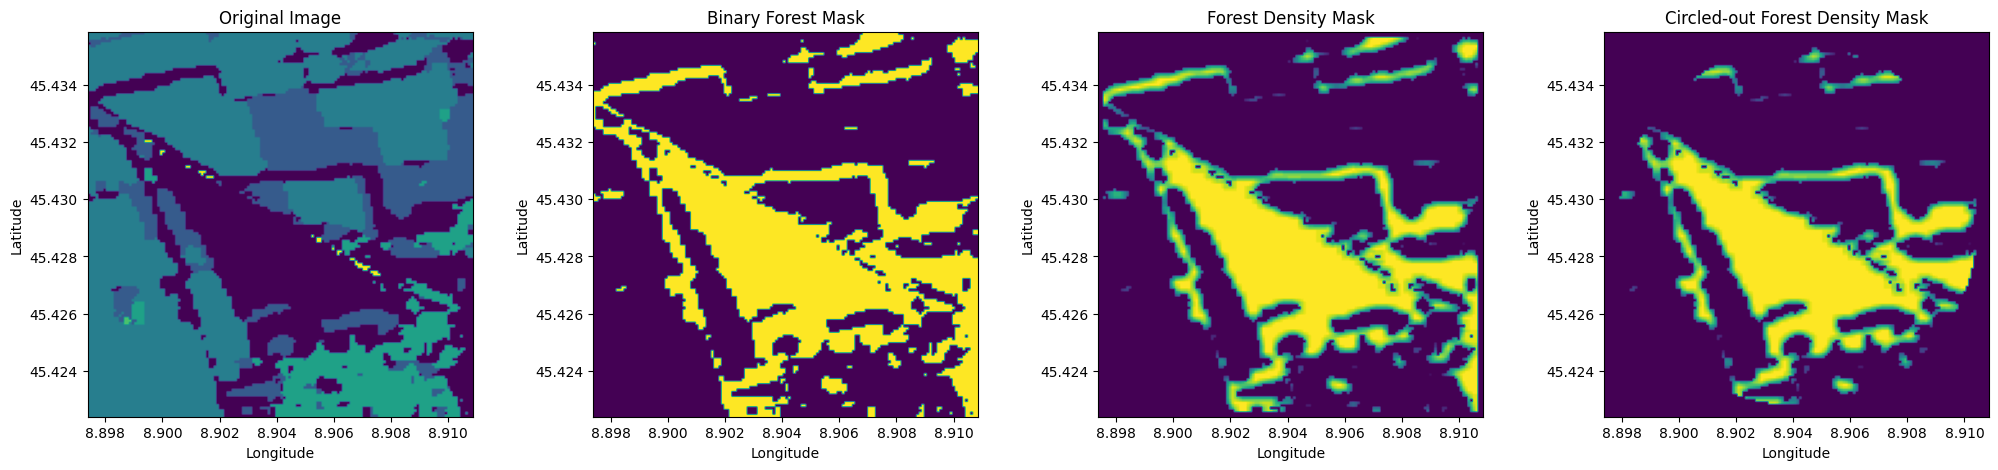

In [37]:
import rasterio
from rasterio.plot import show
from rasterio.windows import Window
import numpy as np
import matplotlib.pyplot as plt

# Inputs
seed_random_point = 2002  # Set random seed. Good ones: 1998
middle_point_radius_pixels = 70  # Radius in pixels
radius_in_meters = 700  # Radius in meters for zeroing
pixel_size = 10  # Pixel size in meters (one pixel represents 10 meters)
n_window = 5  # nxn kernel to calculate forest density around forest pixel


# Load the raster file
with rasterio.open("land_cover_esa_v200_part_4 copy.tif") as src:
    # -----------------------------------------------------------
    # Set middle point of window
    # TODO Replace this, if you want to use a specific point from NFI data
    # Get coordinates for a random point in the image
    np.random.seed(seed_random_point)
    random_row = np.random.randint(
        middle_point_radius_pixels, src.height - middle_point_radius_pixels
    )
    random_col = np.random.randint(
        middle_point_radius_pixels, src.width - middle_point_radius_pixels
    )
    middle_point = (random_row, random_col)
    coord_id = "random"  # TODO: Adjust for site id from NFI data

    # print(middle_point)

    # -----------------------------------------------------------
    # Crop to window
    # Set the additional pixels to expand the window in each direction
    buffer_pixels = min(5, n_window + 5)

    # Calculate the bounds of the window with additional buffer
    row_start = max(0, middle_point[0] - middle_point_radius_pixels - buffer_pixels)
    col_start = max(0, middle_point[1] - middle_point_radius_pixels - buffer_pixels)
    window_width = middle_point_radius_pixels * 2 + buffer_pixels * 2
    window_height = middle_point_radius_pixels * 2 + buffer_pixels * 2

    # Ensure the window does not exceed the image dimensions
    row_end = min(row_start + window_height, src.height)
    col_end = min(col_start + window_width, src.width)

    # Adjust the start if the end is being clipped due to image boundary
    row_start = max(0, row_end - window_height)
    col_start = max(0, col_end - window_width)

    window = Window(
        col_off=col_start,
        row_off=row_start,
        width=window_width,
        height=window_height,
    )

    # -----------------------------------------------------------
    # Read the data from the window
    window_transform = src.window_transform(window)
    image_org_window = src.read(1, window=window)

    # The center point coordinates must be recalculated since the window has been buffered
    center_row = middle_point[0] - row_start
    center_col = middle_point[1] - col_start
    center_point_relative = (center_row, center_col)

    # Create a binary image based on the condition
    image_binary_window = image_org_window.copy()
    image_binary_window = np.where(image_org_window == 10, 1, 0)

    # Apply forest density map to binary image
    forest_density_mask = image_binary_window.copy()
    forest_density_mask = produce_raster_with_forest_density(
        image_binary_window, n_window
    )

    # Now you can call the zero_out_circle function with the adjusted center point
    forest_density_mask_circled = forest_density_mask.copy()
    forest_density_mask_circled = zero_out_circle(
        forest_density_mask_circled, center_point_relative, radius_in_meters, pixel_size
    )

    # -----------------------------------------------------------
    # Extract forest coordinates based on desired method
    # Export forest_density geo dataframe
    forest_density_gdf = extract_nonzero_pixels_to_dataframe(
        forest_density_mask_circled, window_transform
    )

    display(forest_density_gdf)

    forest_density_gdf.to_file(
        "forest_density_site_" + coord_id + " .geojson", driver="GeoJSON"
    )

    # Get closes pixel to center point
    # closest_forest_pixel = bfs_closest_pixel(
    #     center_point_relative, forest_density_mask_circled, target_value=5
    # )
    # print(clostest_forest_pixel)
    # -----------------------------------------------------------
    # Create plots

    # Plot the original, binary, and forest density images side by side
    fig, ax = plt.subplots(1, 4, figsize=(25, 5))

    # Plot original raster
    ax[0].set_title("Original Image")
    ax[0].set_xlabel("Longitude")
    ax[0].set_ylabel("Latitude")
    show(image_org_window, transform=window_transform, ax=ax[0], cmap="viridis")

    # Plot binary raster
    ax[1].set_title("Binary Forest Mask")
    ax[1].set_xlabel("Longitude")
    ax[1].set_ylabel("Latitude")
    show(image_binary_window, transform=window_transform, ax=ax[1], cmap="viridis")

    # Plot forest mask
    ax[2].set_title("Forest Density Mask")
    ax[2].set_xlabel("Longitude")
    ax[2].set_ylabel("Latitude")
    show(forest_density_mask, transform=window_transform, ax=ax[2], cmap="viridis")

    # Plot circled-out forest mask
    ax[3].set_title("Circled-out Forest Density Mask")
    ax[3].set_xlabel("Longitude")
    ax[3].set_ylabel("Latitude")
    show(
        forest_density_mask_circled,
        transform=window_transform,
        ax=ax[3],
        cmap="viridis",
    )